# Setup

In [2]:
import os
import sys
import random
from collections import Counter

import numpy as np
import pyloudnorm as pln
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display
import librosa.display
import ipywidgets
from ipywidgets import widgets

In [3]:
# We're going to use utilities from the core framework
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.config import config_from_args
from src.utils.build import build_device, build_datasets

In [4]:
def build_dataset(name):
    data_path = os.path.abspath(os.path.join("../../processed_data/", name))
    config_path = os.path.abspath(os.path.join("../../../configs/multi_subject_config.json"))
    config = config_from_args([
        f"--data={data_path}",
        f"--config={config_path}",
        f"--dataset=throat_mic_classif",
        f"--stratify=0",
        f"--max_ms=1500",
        f"--norm=0"
    ])
    device = build_device()
    dataset, *_ = build_datasets(config, device)
    return dataset

In [5]:
dataset = build_dataset("multi_subject")

Train set size: 1199
Dev set size: 800
Test set size: 0


In [6]:
print(f"Normal dataset: {len(dataset)} samples")

Normal dataset: 1999 samples


# Load

In [7]:
def get_raw(dataset, idxs=None):
    if idxs is None:
        idxs = range(len(dataset))
        
    raw_data = [dataset.loader.load(i) for i in idxs]

    # load() returns (input, target, is_train)
    raw_inputs, raw_targets, _ = list(zip(*raw_data))
    
    raw_inputs = [d[0] for d in raw_inputs]
    srs, raw_data = list(zip(*raw_inputs))
    sr = srs[0]

    return sr, raw_data, raw_targets

In [8]:
def get_proc(dataset, idxs=None):
    if idxs is None:
        idxs = range(len(dataset))
        
    # Each element is a dictionary with keys 'input' and 'target'
    # Input is a spectogram, target is an encoded label
    processed_data = [dataset[i] for i in idxs]
    processed_inputs = [d["input"].numpy() for d in processed_data]
    processed_targets = [d["target"] for d in processed_data]

    spectogram = [spec[0, :, :] for spec in processed_inputs]
    
    return spectogram

In [9]:
def build_splits(dataset, idxs=None):
    sr, raw_data, raw_targets = get_raw(dataset, idxs=idxs)
    processed = get_proc(dataset, idxs=idxs)
    
    # Make by-label splits
    labels = list(set(list(raw_targets) + ["up", "down", "select", "back", "repeat"]))

    label_splits = {l: {
        "raw": [],
        "proc": [],
    } for l in labels}

    for i, label in enumerate(raw_targets):
        label_splits[label]["raw"].append(raw_data[i])
        label_splits[label]["proc"].append(processed[i])
    
    label_splits["all"] = {}
    label_splits["all"]["raw"] = raw_data
    label_splits["all"]["proc"] = processed
    label_splits["all"]["raw_targets"] = raw_targets

    return label_splits, sr

In [10]:
def build_subject_splits(dataset):
    splits = {}
    loader = dataset.loader
    for i, subject in enumerate(loader.subjects):
        idxs = []
        for session in subject:
            idxs.extend(loader.sessions[session])
        splits[f"subject_{i}"], sr = build_splits(dataset, idxs=idxs)
        print(f"Built subject_{i} splits")
    return splits, sr
        

In [11]:
#splits, sr = build_splits(dataset)
#print(sr)

In [12]:
#all_splits = {
#    "Data": splits,
#}

In [13]:
all_splits, sr = build_subject_splits(dataset)

Built subject_0 splits
Built subject_1 splits
Built subject_2 splits
Built subject_3 splits


# Initial Exploration

In [14]:
plt.rcParams['figure.dpi'] = 100  # Make plots appear larger

## Dataset Size

In [15]:
for name, split in all_splits.items():
    counts = Counter(split["all"]["raw_targets"])
    counts["total"] = len(split["all"]["raw_targets"])
    
    print(f"{name}:")
    for key, value in counts.items():
        print(f"  {key}: {value} samples")

    count_labels = ["Up", "Down", "Select", "Back", "Repeat"]
    counts = [counts[l.lower()] for l in count_labels]

subject_0:
  up: 100 samples
  select: 100 samples
  back: 100 samples
  repeat: 100 samples
  down: 100 samples
  total: 500 samples
subject_1:
  select: 100 samples
  up: 100 samples
  repeat: 100 samples
  down: 100 samples
  back: 100 samples
  total: 500 samples
subject_2:
  select: 99 samples
  back: 100 samples
  up: 100 samples
  down: 100 samples
  repeat: 100 samples
  total: 499 samples
subject_3:
  down: 100 samples
  select: 100 samples
  repeat: 100 samples
  up: 100 samples
  back: 100 samples
  total: 500 samples


## Sample Lengths

In [16]:
def _to_lens(data, sr=sr):
    data = [len(d) / sr * 1000 for d in data]
    if not data:
        return [0]
    return data

def plot_lens(split, axs):
    # Assuming all raw input channels have same length
    lens = [
        _to_lens(split["all"]["raw"]),
        _to_lens(split["up"]["raw"]),
        _to_lens(split["down"]["raw"]),
        _to_lens(split["select"]["raw"]),
        _to_lens(split["back"]["raw"]),
        _to_lens(split["repeat"]["raw"]),
    ]
    len_labels = ["All", "Up", "Down", "Select", "Back", "Repeat"]
    
    axs[0].boxplot(lens, labels=len_labels)
    axs[0].set_ylim(0, 3000)

    axs[1].violinplot(
        lens,
        showextrema=True,
        showmedians=True
    )
    axs[1].set_xticks(list(range(1, len(len_labels) + 1)))
    axs[1].set_xticklabels(len_labels)
    axs[1].set_ylim(0, 3000)


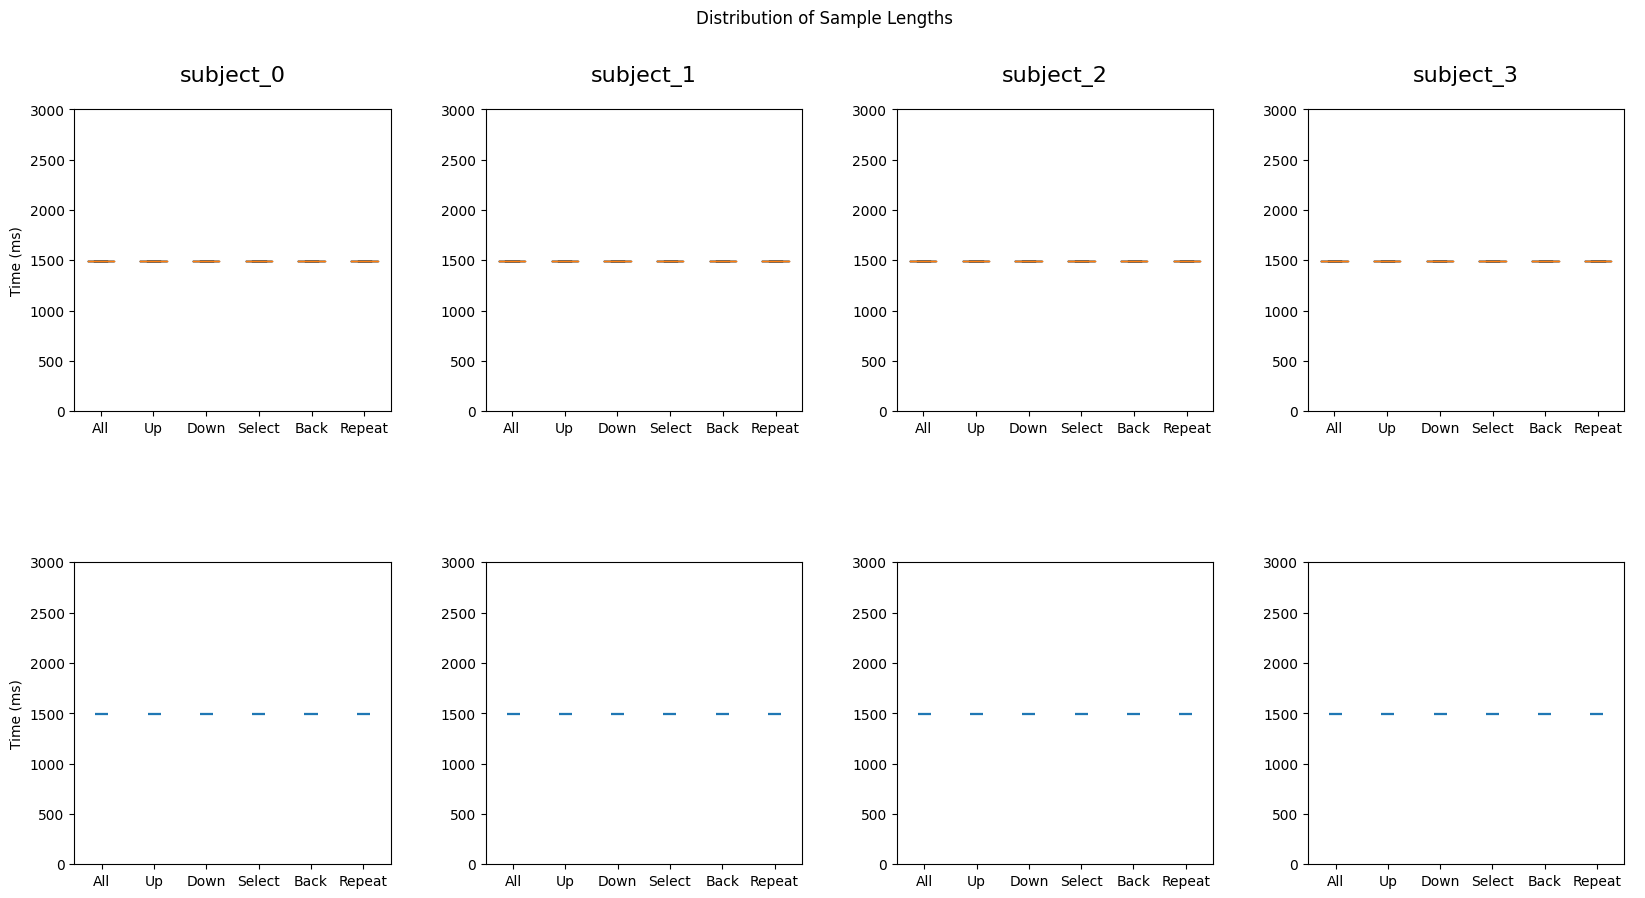

In [54]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(20, 10), sharey=True)
if len(all_splits) == 1:
    axs = [axs]
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    box_ax = fig.add_subplot(2, len(all_splits), i + 1)
    violin_ax = fig.add_subplot(2, len(all_splits), i + 1 + len(all_splits))
    if (i == 0):
        box_ax.set_ylabel("Time (ms)")
        violin_ax.set_ylabel("Time (ms)")
    plot_lens(split, (box_ax, violin_ax))

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("Distribution of Sample Lengths", y=0.98)
plt.show()

## Loudness

In [18]:
def _to_loudness(data, sr=sr):
    meter = pln.Meter(sr)
    data = [d.astype(np.float32) for d in data]
    data = [meter.integrated_loudness(d) for d in data]
    return data if data else [0]

def plot_loudness(split, axs, channel="raw"):
    loudnesses = [
        _to_loudness(split["all"][channel]),
        _to_loudness(split["up"][channel]),
        _to_loudness(split["down"][channel]),
        _to_loudness(split["select"][channel]),
        _to_loudness(split["back"][channel]),
        _to_loudness(split["repeat"][channel]),
    ]
    loudness_labels = ["All", "Up", "Down", "Select", "Back", "Repeat"]

    axs[0].boxplot(loudnesses, labels=loudness_labels)
    #axs[0].set_ylim(0, 80)
    axs[0].set_ylabel("Loudness (dB LUFS)")

    axs[1].violinplot(
        loudnesses,
        showextrema=True,
        showmedians=True
    )
    axs[1].set_xticks(list(range(1, len(loudness_labels) + 1)))
    axs[1].set_xticklabels(loudness_labels)
    #axs[1].set_ylim(0, 80)
    axs[1].set_ylabel("Loudness (dB LUFS)")

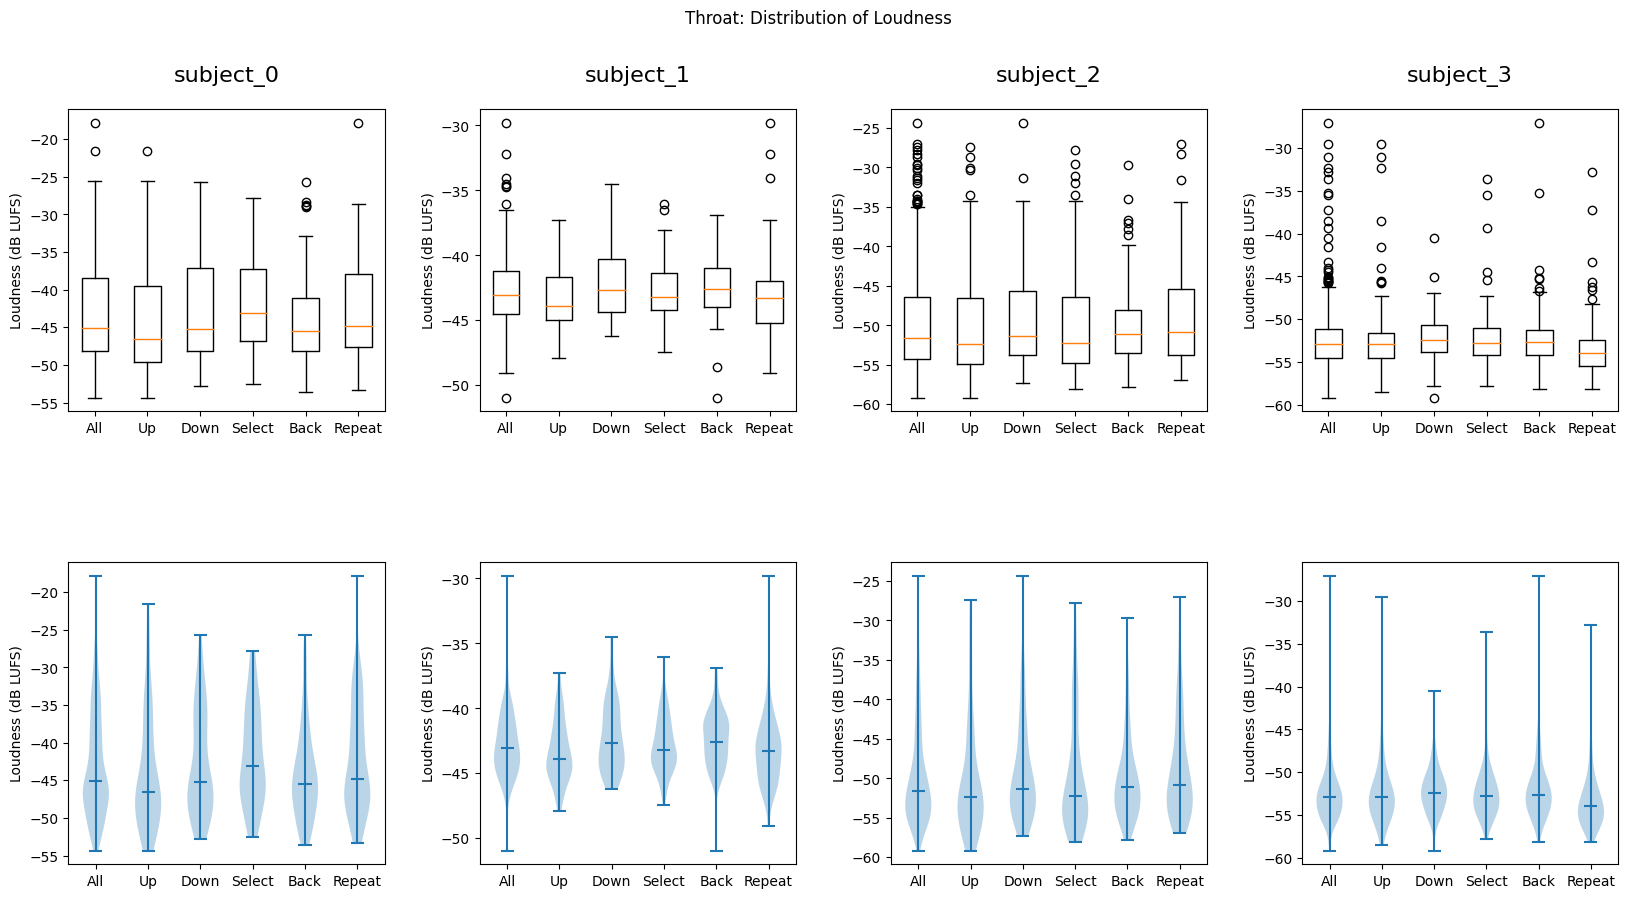

In [53]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(20, 10), sharey=True)
if len(all_splits) == 1:
    axs = [axs]
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    box_ax = fig.add_subplot(2, len(all_splits), i + 1)
    violin_ax = fig.add_subplot(2, len(all_splits), i + 1 + len(all_splits))
    if (i == 0):
        box_ax.set_ylabel("Time (ms)")
        violin_ax.set_ylabel("Time (ms)")
    plot_loudness(split, (box_ax, violin_ax))

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("Throat: Distribution of Loudness", y=0.98)
plt.show()

# Visualizing Samples

In [41]:
num_samples = 12
label = "back"
for split in all_splits.values():
    _num_samples = min(num_samples, len(split[label]["raw"]))
    sample_idxs = random.sample(list(range(len(split[label]["raw"]))), _num_samples)
    sample_idxs.extend([0 for _ in range(num_samples - _num_samples)])
    split["sample_idxs"] = sample_idxs
    if label == "all":
        split["sample_targets"] = split["all"]["raw"]
    else:
        split["sample_targets"] = [label for _ in range(len(split[label]["raw"]))]

In [42]:
def plot_wave(sr, raw, ax, title=None):
    img = librosa.display.waveplot(raw.astype(np.float32), sr=sr, ax=ax)    
    ax.set_ylim(-0.1, 0.1)
    ax.set_xlim(0, 1.5)
    ax.set_xticks(np.arange(0, 1.6, 0.5))
    if title:
        ax.set_title(title, fontsize=12)
    return img
    # display(ipd.Audio(raw, rate=sr))
    
def plot_spec(sr, spec, ax, title=None):
    spec_nan = np.isnan(np.sum(spec))
    if spec_nan:
        return None;
    img = librosa.display.specshow(
        spec, sr=sr, x_axis='time', y_axis='mel', hop_length=512, ax=ax,
        vmin=-60, vmax=20, cmap="plasma"
    )
    if title:
        ax.set_title(title, fontsize=12)
    return img
    # display(ipd.Audio(raw, rate=sr))

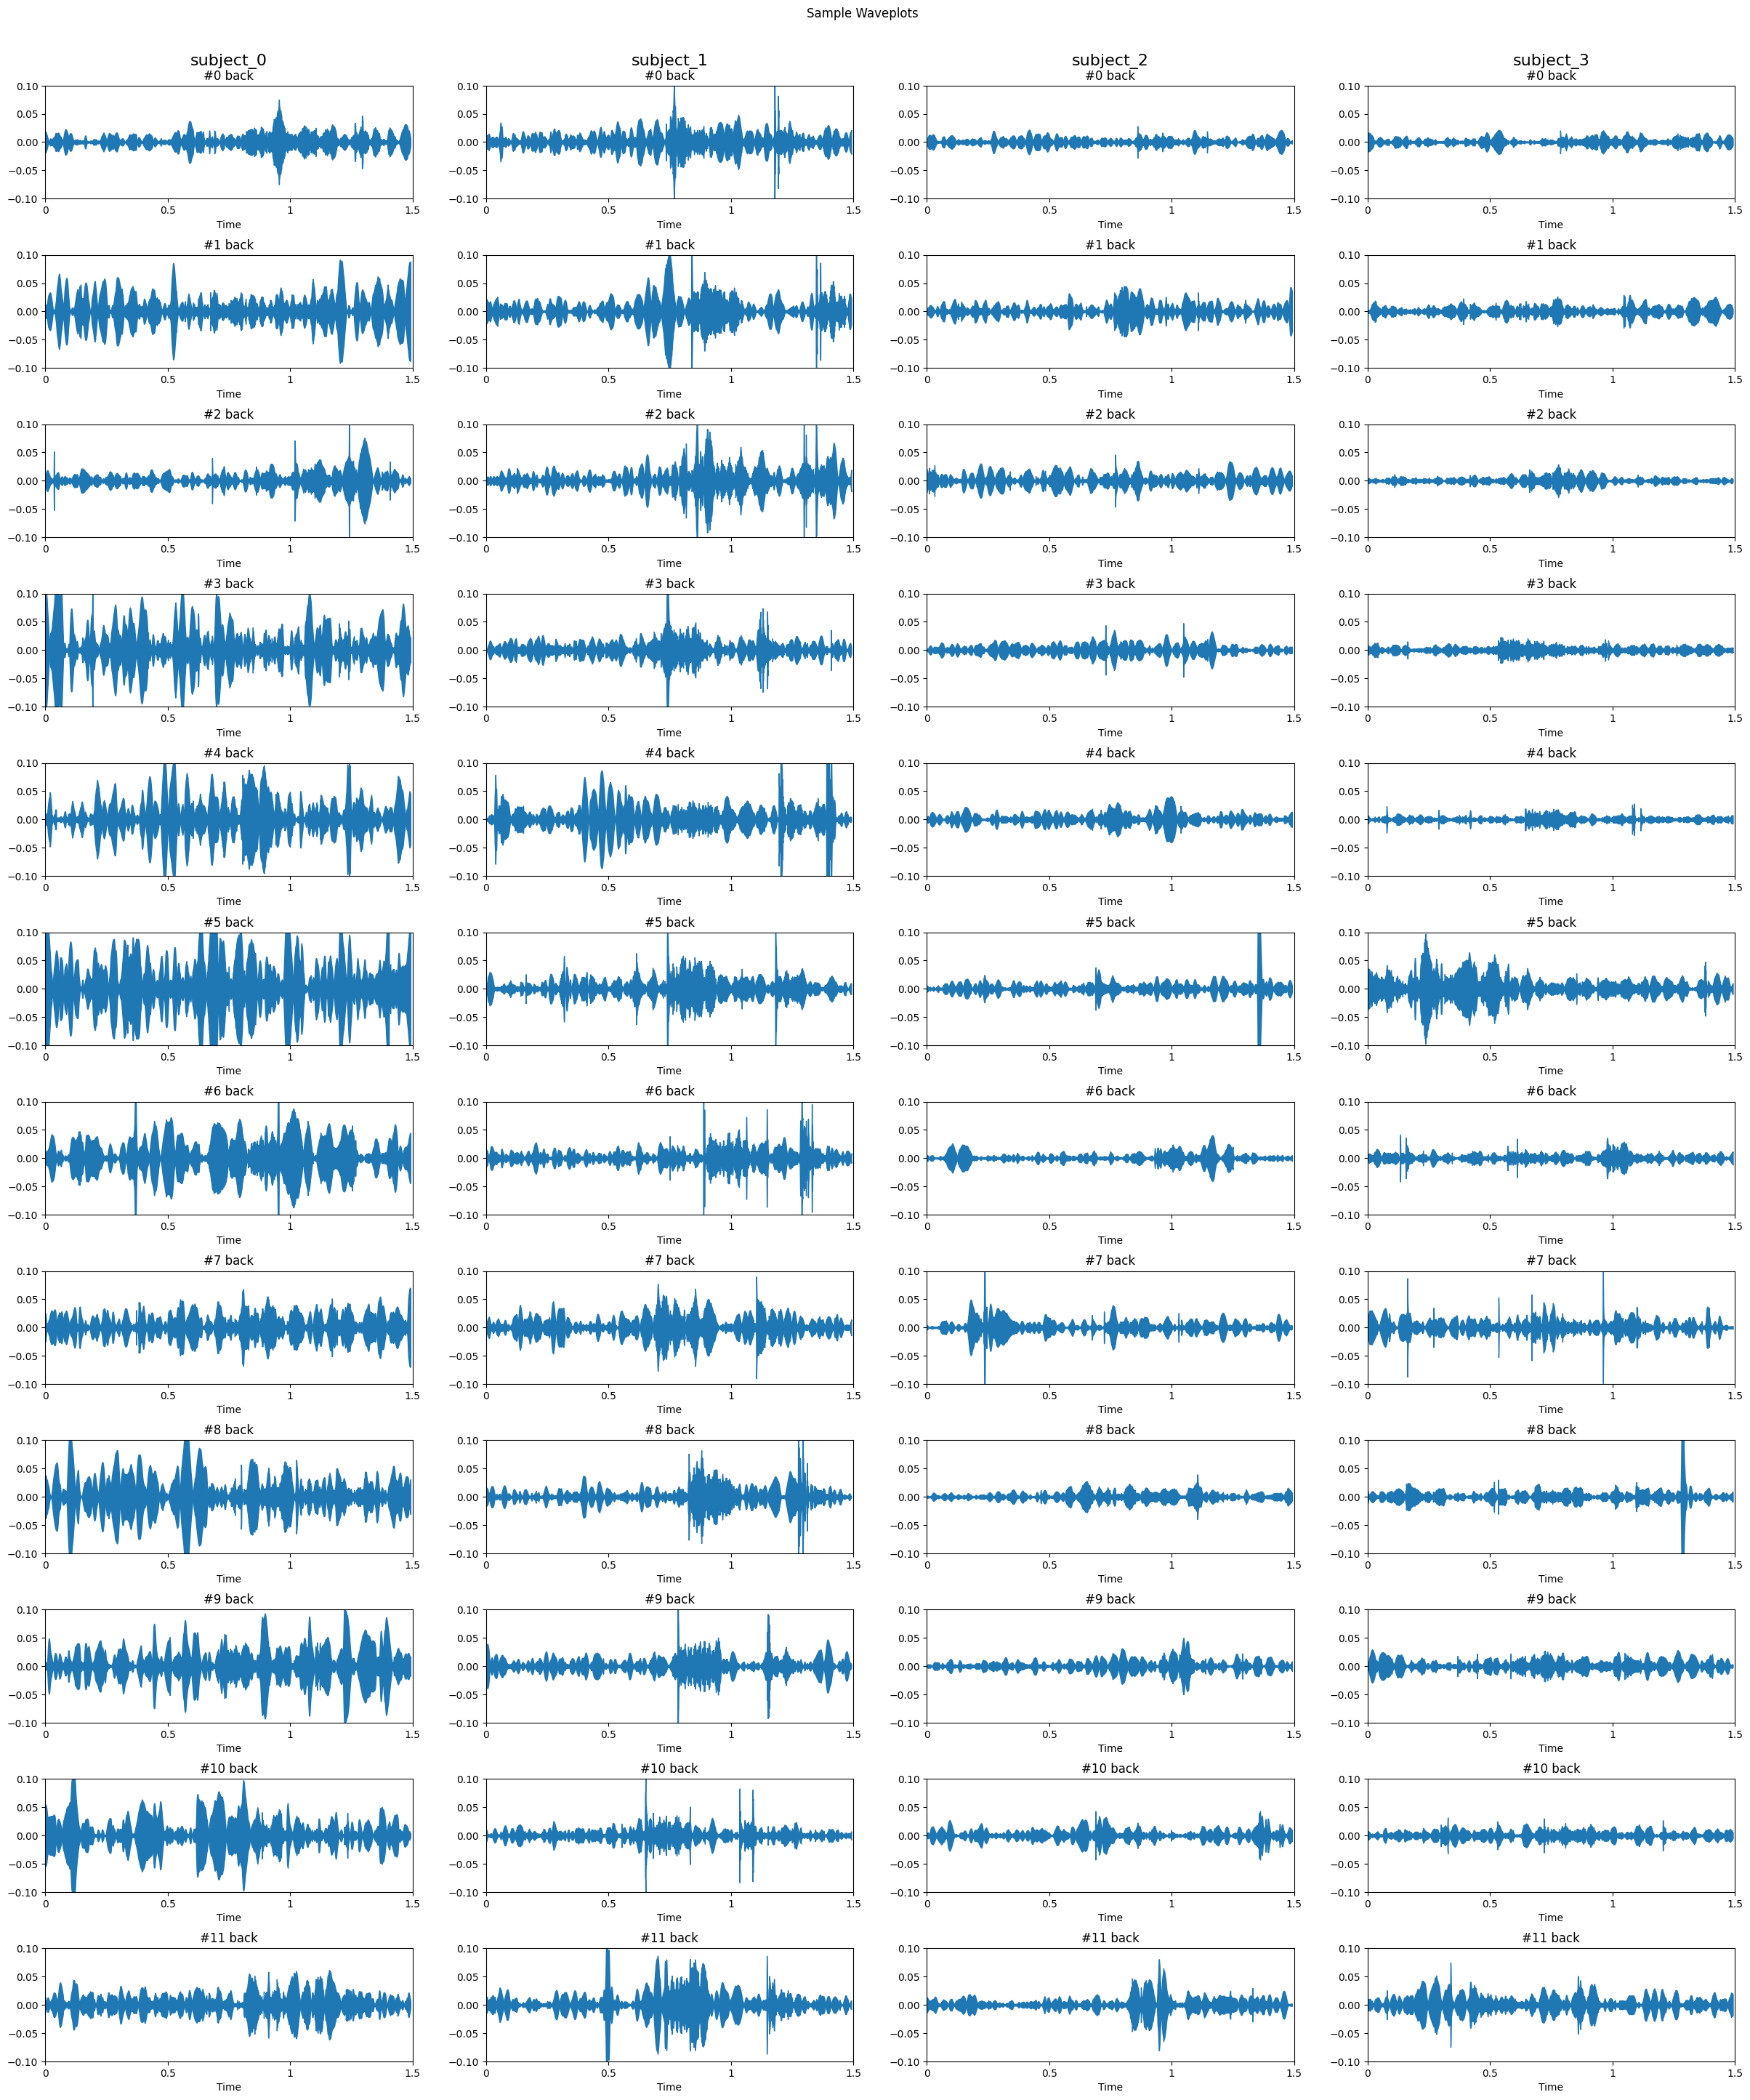

In [43]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(30, num_samples * 3), sharey=True)
if len(all_splits) == 1:
    axs = [axs]
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    if name == "Error":
        continue
    for n, idx in enumerate(split["sample_idxs"]):
        ax = fig.add_subplot(num_samples, len(all_splits), n * len(all_splits) + i + 1)
        plot_wave(sr, split[label]["raw"][idx], ax, f"#{n} {split['sample_targets'][idx]}")
        
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.suptitle("Sample Waveplots", y=0.91)
plt.show()

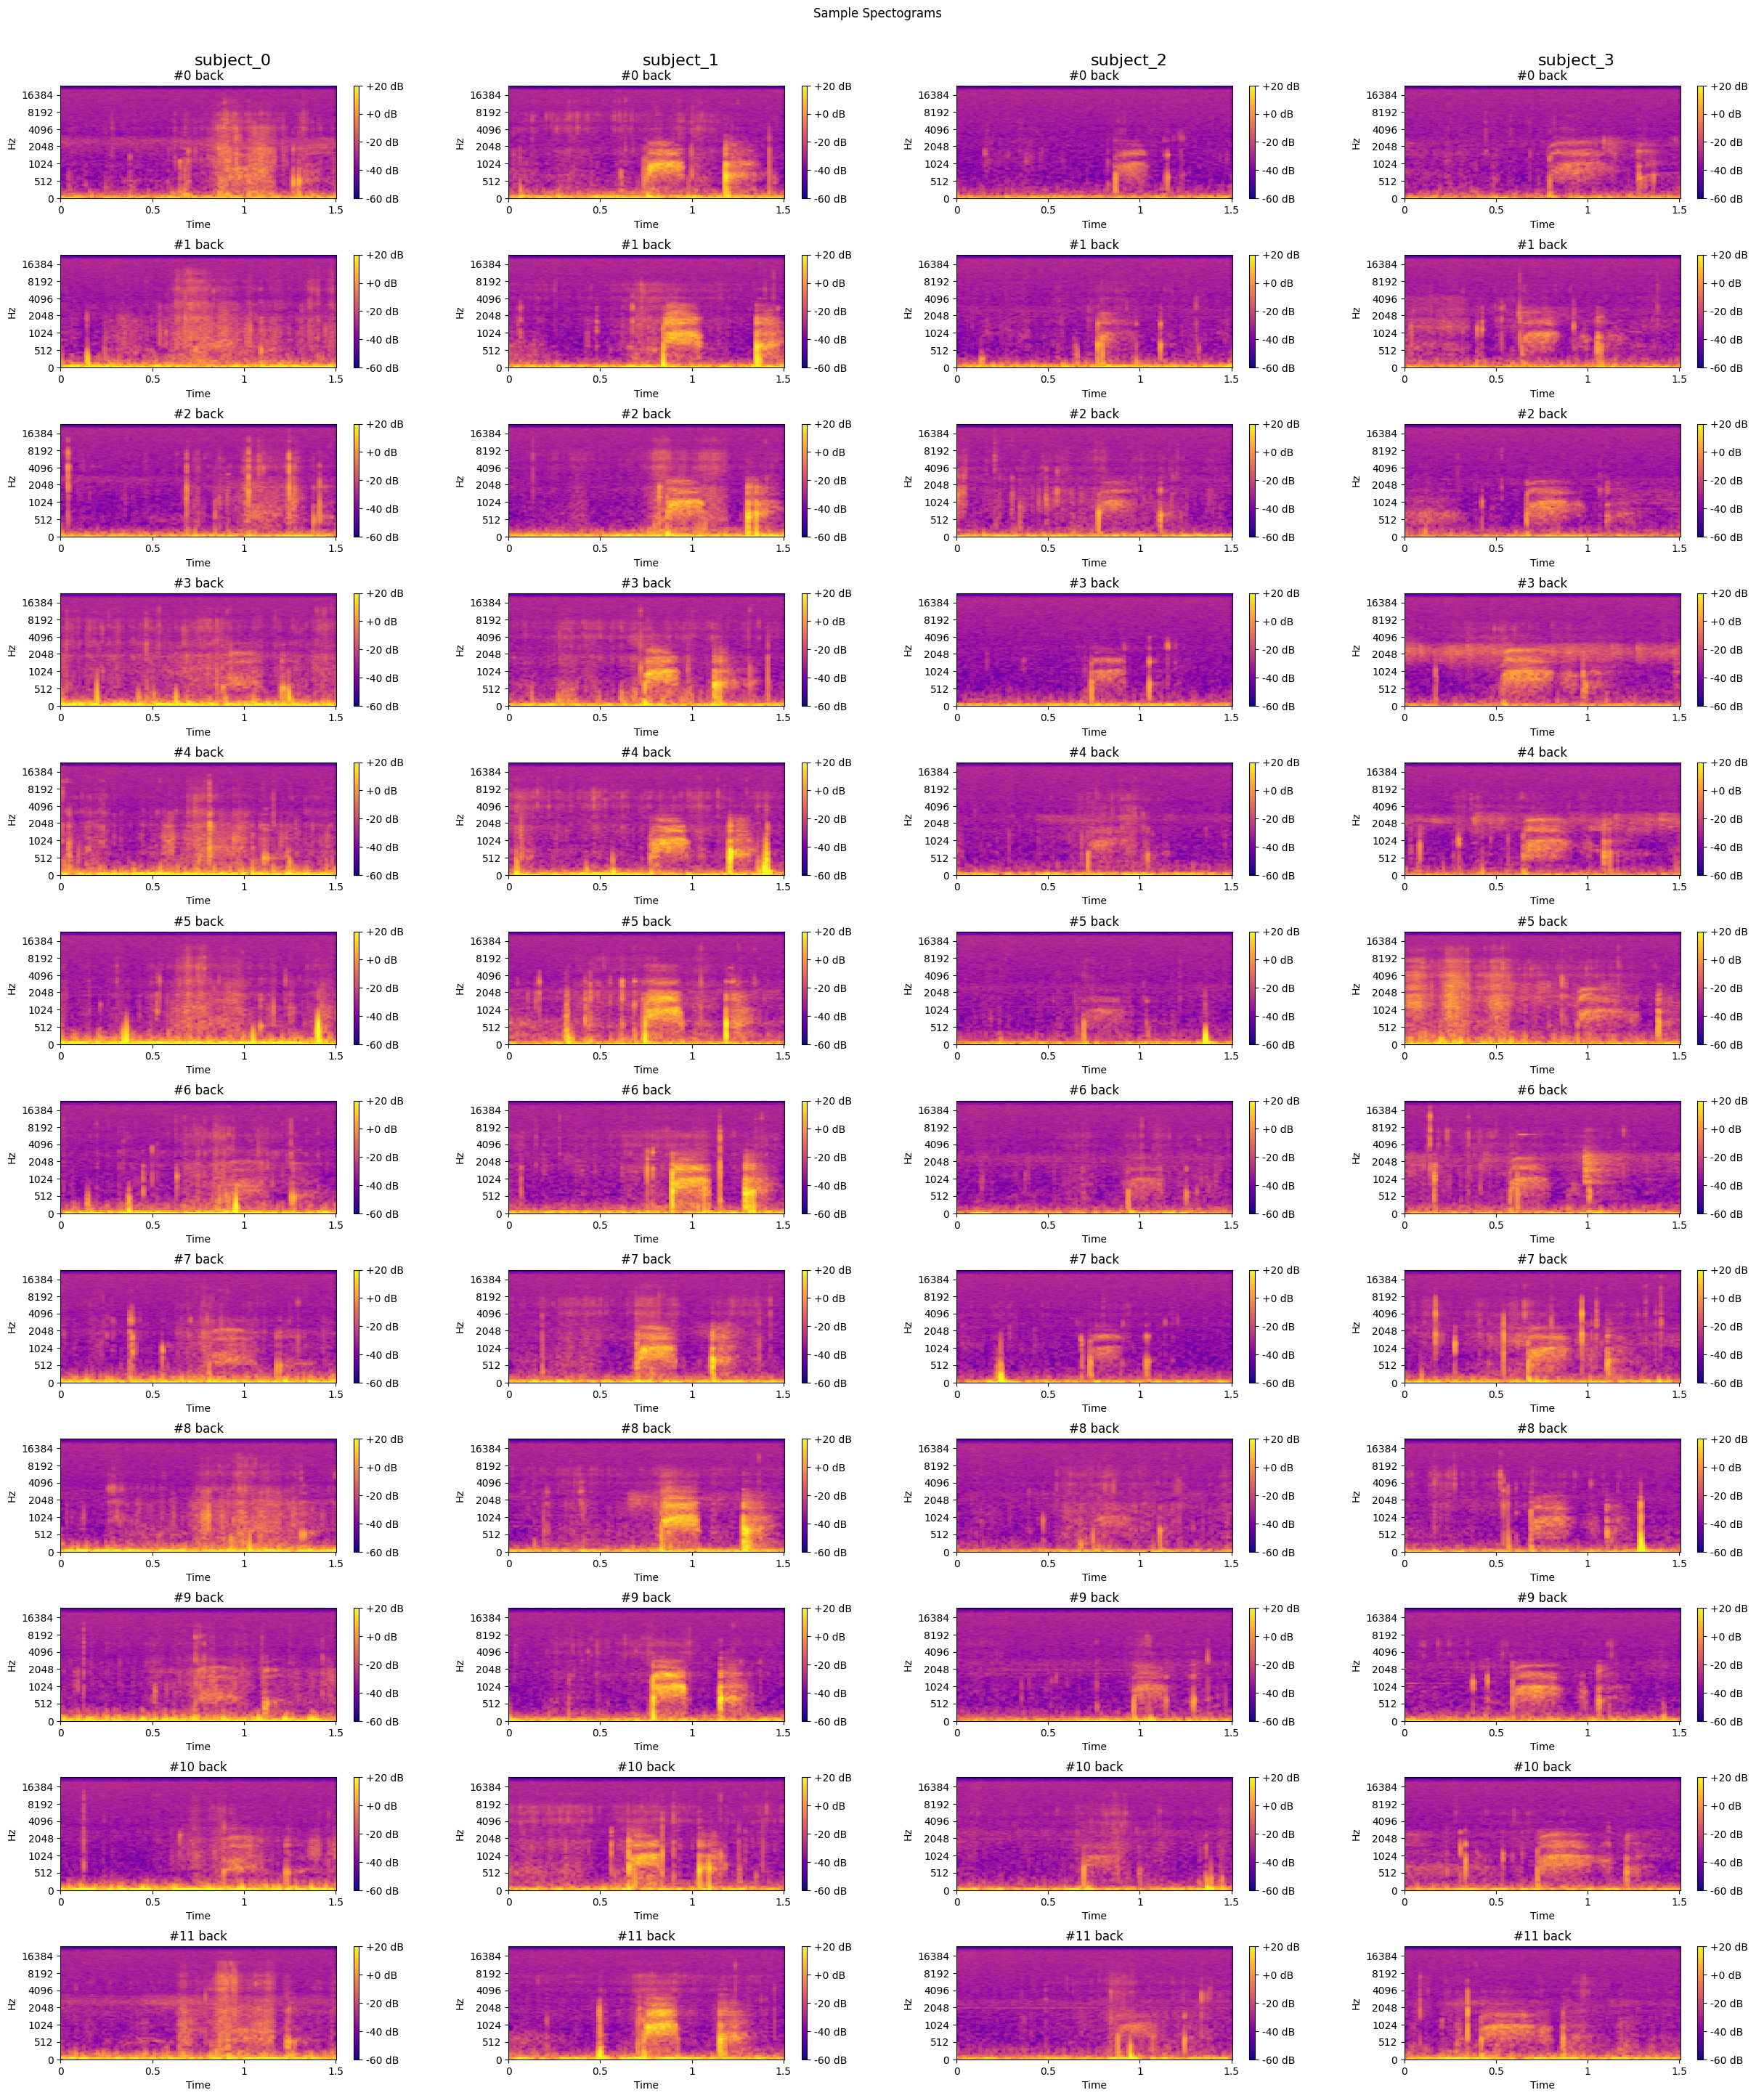

In [44]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(30, num_samples * 3), sharey=True)
if len(all_splits) == 1:
    axs = [axs]
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False

for i, (name, split) in enumerate(all_splits.items()):
    if name == "Error":
        continue
    for n, idx in enumerate(split["sample_idxs"]):
        ax = fig.add_subplot(num_samples, len(all_splits), n * len(all_splits) + i + 1)
        img = plot_spec(sr, split[label]["proc"][idx], ax, f"#{n} {split['sample_targets'][idx]}")
        if img:
            fig.colorbar(img, ax=ax, format="%+2.f dB")
        
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle("Sample Spectograms", y=0.91)
plt.show()

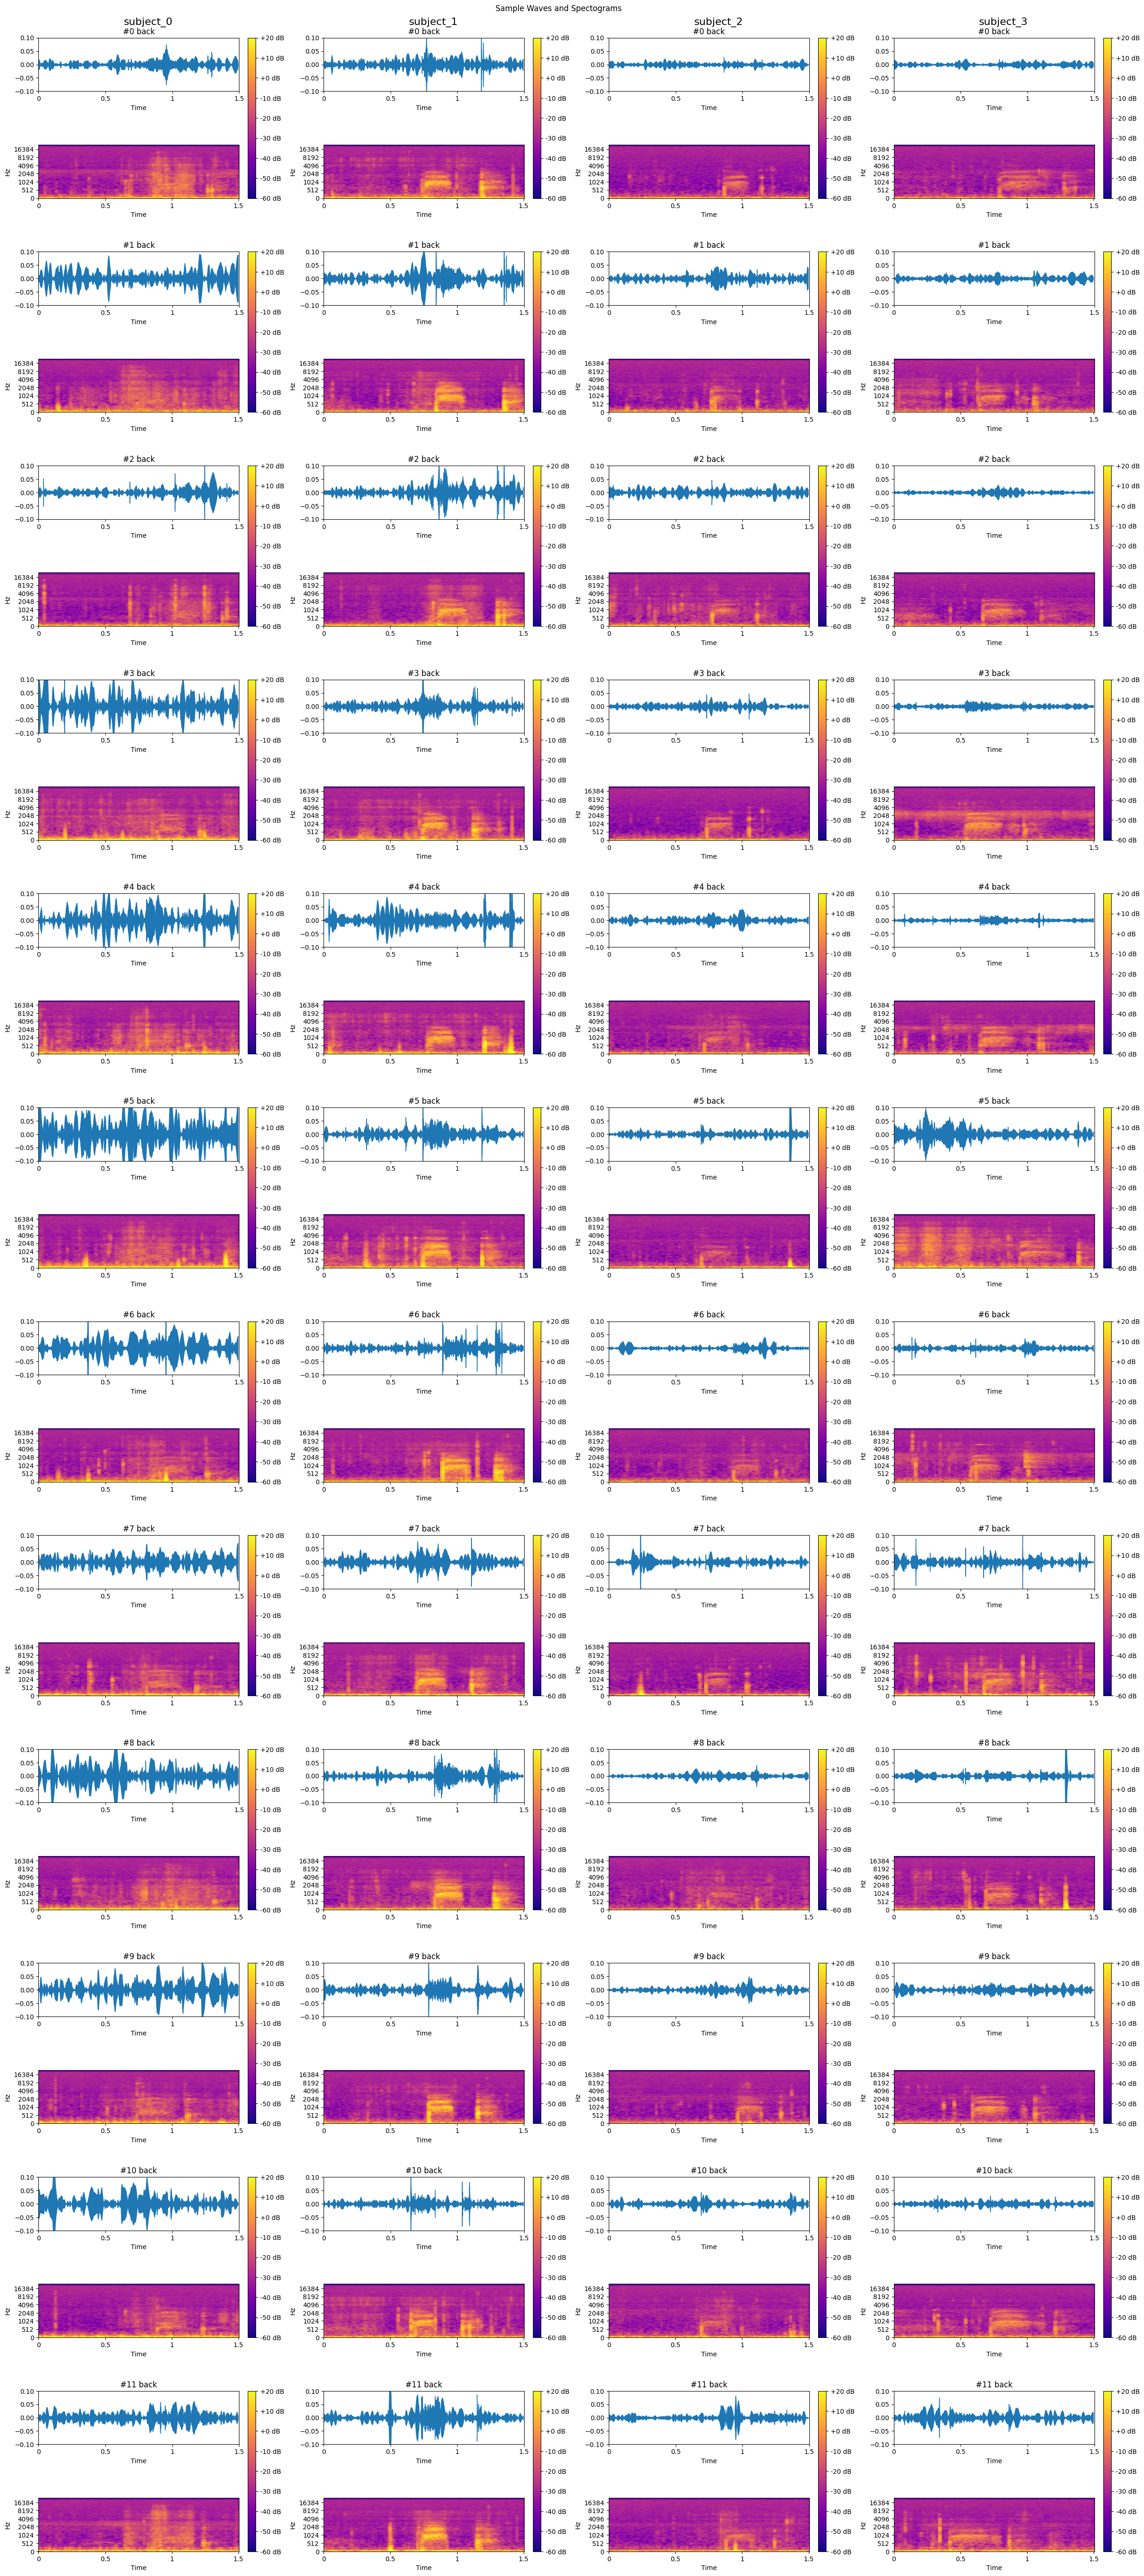

In [49]:
fig, axs = plt.subplots(1, len(all_splits), figsize=(30, num_samples * 6), sharey=True)
if len(all_splits) == 1:
    axs = [axs]
for row, ax in enumerate(axs):
    ax.set_title(list(all_splits.keys())[row], fontsize=16, pad=20)
    ax.tick_params(labelcolor=(1.,1.,1., 0.0), length=0)
    ax._frameon = False
plt.subplots_adjust(hspace=1, wspace=0.3)

for i, (name, split) in enumerate(all_splits.items()):
    if name == "Error":
        continue
    for n, idx in enumerate(split["sample_idxs"]):
        wave_loc = n * 2 * len(all_splits) + i + 1
        spec_loc = wave_loc + len(all_splits)
        ax_wave = fig.add_subplot(num_samples * 2, len(all_splits), wave_loc)
        ax_spec = fig.add_subplot(num_samples * 2, len(all_splits), spec_loc)
        plot_wave(sr, split[label]["raw"][idx], ax_wave, f"#{n} {split['sample_targets'][idx]}")
        img = plot_spec(sr, split[label]["proc"][idx], ax_spec)
        if img:
            fig.colorbar(img, ax=[ax_wave, ax_spec], format="%+2.f dB", fraction=0.046, pad=0.04)
        
plt.suptitle("Sample Waves and Spectograms", y=0.89)
plt.show()

In [ ]:
from ipywidgets import Layout, Button, Box

items_layout = Layout(width='20%')
box_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    width='100%'
)

first_row = []
for name in all_splits.keys():
    out = widgets.Output(layout=items_layout)
    with out:
        display(ipd.Pretty(name))
    first_row.append(out)
col = [Box(children=first_row, layout=box_layout)]
        
for n in range(num_samples):
    row = []
    for i, (name, split) in enumerate(all_splits.items()):
        idx = split["sample_idxs"][n]
        raw = split[label]["raw"][idx]
        out = widgets.Output(layout=items_layout)
        with out:
            display(ipd.Pretty(f"#{n} {split['sample_targets'][idx]}"))
            display(ipd.Audio(raw, rate=sr))
        row.append(out)
    col.append(Box(children=row, layout=box_layout))
widgets.VBox(col)
    